<a href="https://colab.research.google.com/github/lucas-pinto/NUIN443/blob/main/problemSets/NUIN443_ps3_ClusteringEtc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROBLEM SET 3: PCA, CLUSTERING & CLASSIFICATION #

Here we will review some of the key concepts from the clustering and classification lecture. <br>
We will first do PCA on some Pinto Lab widefield data, and use the reduced dimensionality to cluster cortical areas with K-means. <br>
We will then try to classify pixels from two areas with linear or kernel SVMs. Have fun! <br>

In [1]:
# PROBLEM SET INTRO AND SETUP
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import zscore
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from scipy.stats import zscore
import math

%matplotlib widget
%matplotlib widget

In [2]:
# LOAD DATA
#!wget -nc https://www.dropbox.com/scl/fi/jqqug0ucp6chbj2szr5j8/nuin443_wf_intothevoid_data.pickle?rlkey=ix7ximcjm190baoxg2dlkkbjn&dl=0

## Problem 1: PCA ##

**1a**. Load a \\(\Delta F / F \\) data matrix (dimensions: 1000 imaging frames (i.e. time) x 5563 pixels (i.e. space)). The pixels span mulitple areas of the dorsal cortex (left hemisphere), and were imaged as a mouse ran in the dark (a.k.a. the "Into the Void" protocol). You will also need some other variables (see comments below for explanation of data formats). <br>
**1b**. We will use these data to cluster pixels into brain areas. But first we will need to do some dimensionality reduction, as it is unfeasible to use a 1000-dimensional vector for clustering. Use PCA to do this, but compute the principal components and eigenvalues directly from the SVD function (i.e., without using any "PCA" functions from statistical packages). Do this twice: first, to obtain spatial components to help you guide choose \\(K\\); second, for temporal components, to reduce the dimensionality of your clustering problem. <br>
**1c**. Plot the eigenvalues for spatial and temporal components. Where are the elbows? What do these results tell you about dimensionality of large-scale dynamics? Do you think this is fixed or does it depend on what the behavior is? <br>

In [3]:
# 1a. Load data
filename    = '../data/nuin443_wf_intothevoid_data.pickle?rlkey=ix7ximcjm190baoxg2dlkkbjn'
with open(filename, 'rb') as handle:
    [dff,nan_idx,area_id_image,area_names,area_lbl] = pickle.load(handle)

# dff           : frames x pixels matrix
# nan_idx       : a vector indicating which pixels were masked to occlude vasculature and off-implant pixels.
#                 You will need to reconstruct the images, but I will provide the function for that
# area_id_image : and image with cortical areas coded according to the Allen Brain Atlas
# area_names    : a list of unique cortical areas
# area_lbl      : a list assigning an area name to each pixel in the data

In [4]:
# 1b. Do PCA of the dff matrix in time and space (i.e., along different dimensions of the matrix)
# Do it using np.linalg.svd
# hint: you can use sklearn.decompose.PCA to check your results
from sklearn.decomposition import PCA

dff_time = zscore(dff)
dff_space = zscore(dff.T)
U1,S1,V1 = np.linalg.svd(dff_time)
U2,S2,V2 = np.linalg.svd(dff_space)

PCA1 = PCA(n_components = dff.shape[0])
PCA2 = PCA(n_components = dff.shape[0])

In [5]:
PCA1.fit(dff_time)
PCA2.fit(dff_space)

PCA(n_components=1000)

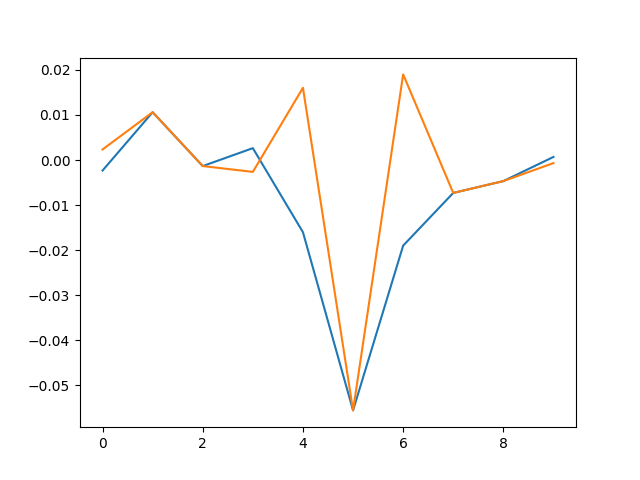

In [6]:
fig, ax = plt.subplots()
ax.plot(V1[:10,0])
ax.plot(PCA1.components_[:10,0])

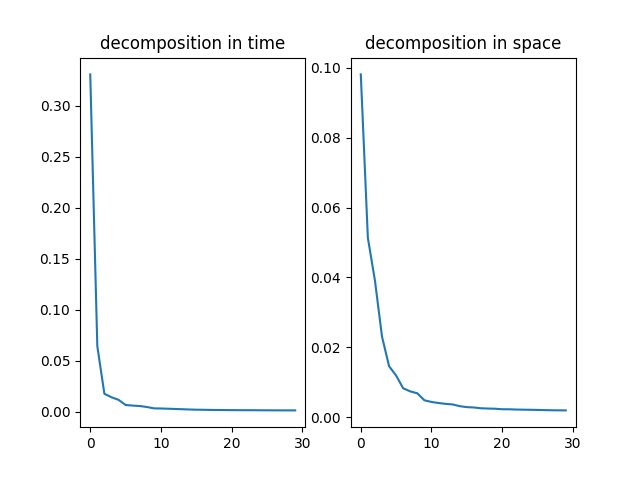

In [7]:
# 1c.i. Plot the fraction variance explained for the first 30 components
fig, ax1 = plt.subplots(ncols=2)
ax1[0].set_title('decomposition in time')
ax1[0].plot(np.power(S1,2)[:30] / np.sum(np.power(S1,2)))
ax1[1].set_title('decomposition in space')
ax1[1].plot(np.power(S2,2)[:30] / np.sum(np.power(S2,2)))

In [8]:
# 1c.ii. What do these results tell you about dimensionality of large-scale dynamics?
# Do you think this is fixed or does it depend on what the behavior is?
# (answer as a comment below)

#most of the variance is captured by a low-d manifold. This definitely depends on the behavior --- i'd imagine non-sterotyped behavior is higher dimensinoal 




## Problem 2: K-means ##

Now we will get set up to cluster the dff decomposition in time.

**2a**. Write your own K-means function. <br>
**2b**. Write your own function to compute the Calinski–Harabasz (CH) index. <br>
**2c**. Test your function with some toy data, varying \\(K\\) between 2 and 5 and plotting CH and clustering results. <br>

In [9]:
# 2a. K-means function
def kmeans(X,K,maxiter=100,initial_value=None,doZscore=True):
    # zscore if required
    if doZscore:
        X      = zscore(X)

    # pick a random initial value roughly within the data scale
    if initial_value is None:
        mean_x        = np.mean(X,axis=0)
        std_x         = np.std(X,axis=0)
        initial_value = np.random.normal(size=(K,np.size(X,axis=1)),scale=1)*std_x+mean_x
    
    #some structures to hold data
    cluster_means = initial_value #cluster means
    num_samples = X.shape[0]
    dists = np.zeros((num_samples, K)) #holds didstances

    
    for iterz in np.arange(maxiter):

        # now set up and iterate between the "E" and "M" steps
        for k in np.arange(K):
            dists[:,k] = np.linalg.norm(X-cluster_means[k,:], axis=1) #euclidean distance
        clusters = np.argmin(dists, axis=1)

        #recalculate means
        for k in np.arange(K):
            cluster_means[k,:] = np.mean(X[clusters==k], axis=0)
            
    #lets now return clusters/cluster means
    clustered_data = []
    #final clustering step
    for k in np.arange(K):
        dists[:,k] = np.linalg.norm(X-cluster_means[k,:], axis=1) #euclidean distance
    clusters = np.argmin(dists, axis=1)
    
    for k in np.arange(K):
        clustered_data.append(X[clusters==k])
        
    return clustered_data, clusters # clustesr=ids
        

        
    
    #expectation step


In [10]:
# 2b. Calinski–Harabasz index
#X is a list of lists
def ch_index(X,clust_id):
    n_samples = np.vstack(X).shape[0]
    all_mean = np.mean(np.vstack(X), axis=0)
    BCSS=0
    WCSS = 0
    for k in np.arange(clust_id):
        cluster = X[k]
        mean_cluster = np.mean(cluster, axis=0)
        BCSS +=len(cluster) * np.linalg.norm(mean_cluster - all_mean)
        WCSS += np.sum(np.linalg.norm(cluster - mean_cluster, axis=1))
    
    return (BCSS / (clust_id-1)) / (WCSS/(n_samples - clust_id))



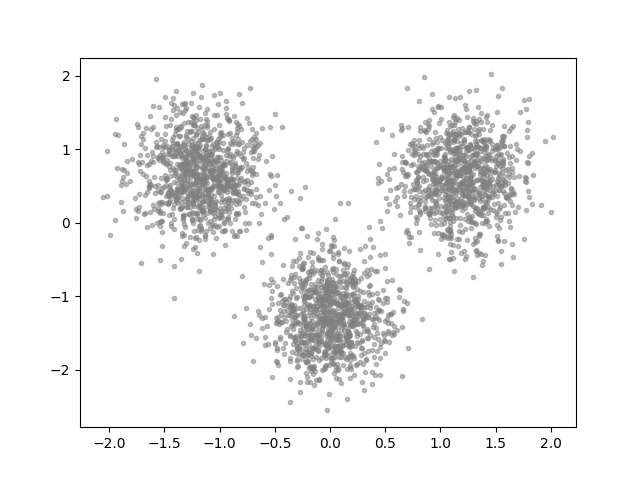

In [12]:
# 2c.i Generate 3 clusters of toy data
m1  = np.array([0,0])
m2  = np.array([6,6])
m3  = np.array([-6,6])
cov = np.array([[2,0],[0,2]])
x1  = np.random.multivariate_normal(m1,cov,size=1000)
x2  = np.random.multivariate_normal(m2,cov,size=1000)
x3  = np.random.multivariate_normal(m3,cov,size=1000)
X   = zscore(np.concatenate((x1,x2,x3),axis=0))

# plot data to visualize it
plt.figure()
plt.scatter(X[:,0],X[:,1],marker='.',alpha=0.5,c='grey')
plt.show()

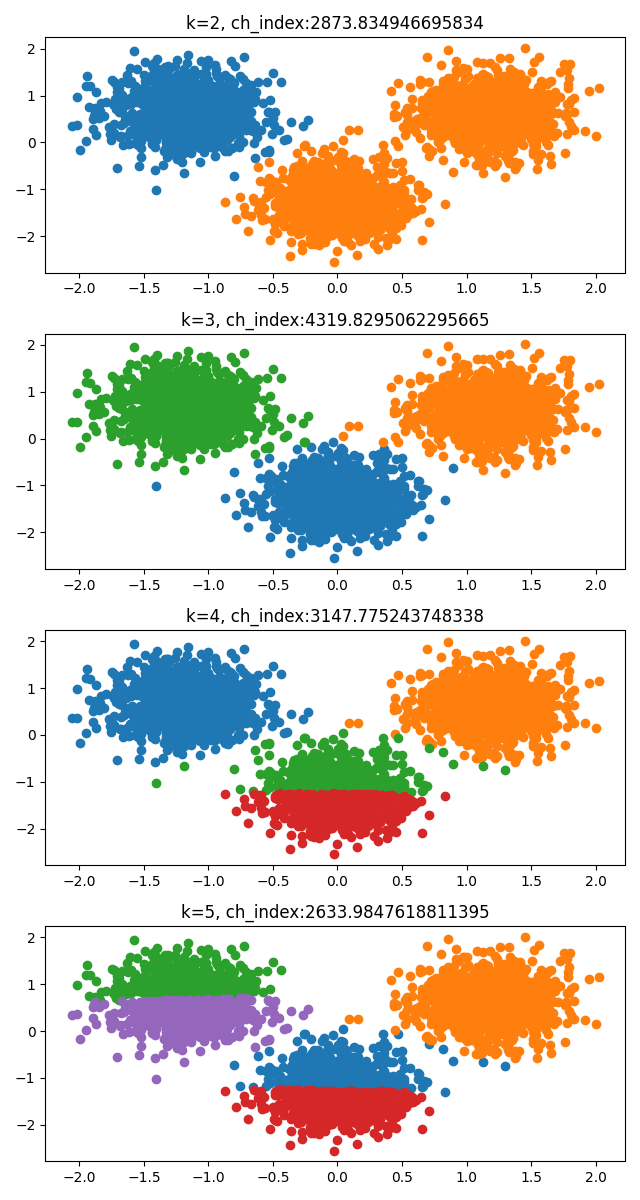

In [13]:
# 2.c.ii. Test your K means function with Ks between 2 and 5
# and compute CH index for each K
# Plot CH statistic and cluster assignments for all Ks
Ks = np.arange(2,6)

fig, ax = plt.subplots(nrows=len(Ks))

for idx, K in enumerate(Ks):
    clustered_data, _ = kmeans(X, K=K)
    chidx = ch_index(clustered_data, K)
    ax[idx].set_title(f'k={K}, ch_index:{chidx}')
    for cluster in clustered_data:
        ax[idx].scatter(cluster[:,0], cluster[:,1])
fig.set_figheight(12)
fig.tight_layout()
        
    





### Problem 3: Clustering widefield imaging data ##

Now we're ready to cluster the widefield data using your functions!

**3a**. First, based on the elbow in the eigenvalues, select \\(n\\) first principal components in time. That is, we want to cluster a matrix of dimensions \\(pixels \times n\\). <br>
**3b**. Now we will choose a range of \\(K\\) based on the spatial PCs. Pick a central \\(K\\) as the elbow in the eigenvalues, and choose \\(K\\) to vary between +/- 4 of the elbow. <br>
**3c**. Now run K-means for each value of \\(K\\), and plot CH as a function of \\(K\\). Pick the best one.  <br>
**3d**. Plot the clusters for the selected \\(K\\) in brain space using the provided function. If you want you can compare to anatomical area labels. <br>

In [14]:
# 3a. Select n principal components in time and assemble a matrix for clustering
#elbow looks like 6
n=6


dff_space_PCs = PCA2.transform(dff_space)[:, :n]

In [15]:
# 3b. Based on space PCA eigenvalues, choose K to vary between +/- 4 of elbow.
Ks = np.arange(n-4, n+4)


best_k: 2


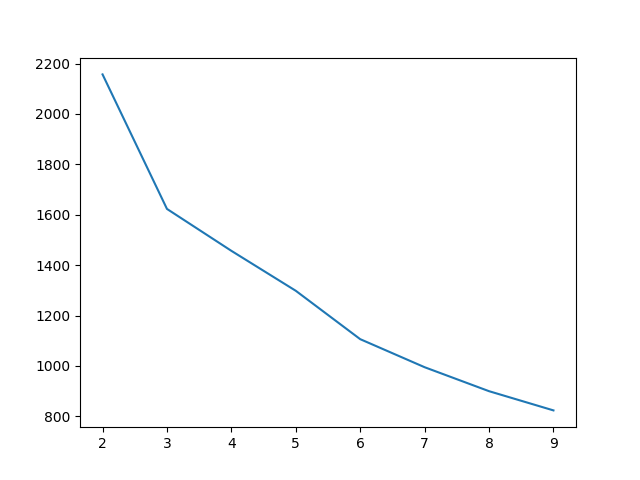

In [16]:
# 3c. Now run K-means for each value of K, and plot CH as a function of K.
ch_index_list = []
cids = []
for idx, K in enumerate(Ks):
    clustered_data, cid = kmeans(dff_space_PCs, K=K)
    ch_index_list.append(ch_index(clustered_data, K))
    cids.append(cid)

# Use your kmeans and CH functions to decide optimal k


# plot CH
fig2, ax2 = plt.subplots()
ax2.plot(Ks, ch_index_list)

best_k = Ks[np.argmax(ch_index_list)]
best_cid = cids[np.argmax(ch_index_list)]
print(f'best_k: {best_k}')


In [17]:
# 3d.i. Use this function to convert your vector of cluster IDs into an image of the left hemisphere
# you will transform a vector of data into an image with masked pixels filled in as NaN
# note that nan_idx is in the pickled data and already loaded
#
# call it like this: make_brain_image(cid,nan_idx), where cid is a vector of cluster labels

def make_brain_image(vec_in,nan_idx,imsize=[128,128]):
    xx                = np.array(vec_in).reshape((-1))
    nidx              = nan_idx.reshape((-1))
    vec_out           = np.zeros(imsize[0]*imsize[1])
    vec_out[nan_idx]  = np.nan
    vec_out[~nan_idx] = xx

    return np.transpose(vec_out.reshape((imsize[0],imsize[1])))[:,np.arange(65)]


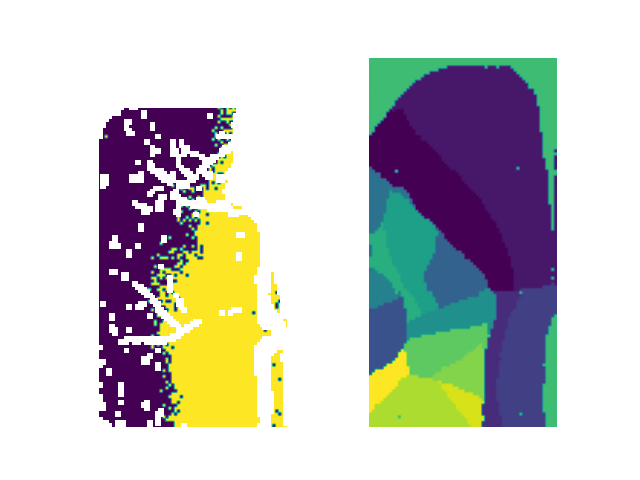

In [18]:
# 3d.ii. Plot the clusters for the selected K in brain space using the provided function

# FILL IN: define cid as the labels for best K
cid=best_cid

# plot cluster assignment
plt.figure()
plt.subplot(121)
plt.imshow(make_brain_image(cid,nan_idx))
ax = plt.gca()
ax.set_axis_off()

# plot Allen brain areas (the apparently different dimensions are due to pixel masking)
plt.subplot(122)
plt.imshow(area_id_image)
ax = plt.gca()
ax.set_axis_off()

### Problem 4: Classification using SVMs ##

Finally, we will use the same dataset to try to classify which of two areas a pixel belongs to, based on the first two temporal PCs. We will compare the performance of a vanilla linear SVM with that of one using a radial basis functions (rbf) kernel. This is mostly pre-coded, the point is more illustrating the difference in what the two types of SVMs can accomplish.

**4a**. Select pixels from the primary visual cortex (V1) or the trunk subregion of the somatosensory cortex. Plot the PC1 and PC2 values for each pixel. Do you think these will be linearly separable? <br>
**4b**. Train a linear or kernel SVM using 10-fold cross -validation. Print the average cross-validated accuracy. Were your suspicions confirmed? <br>

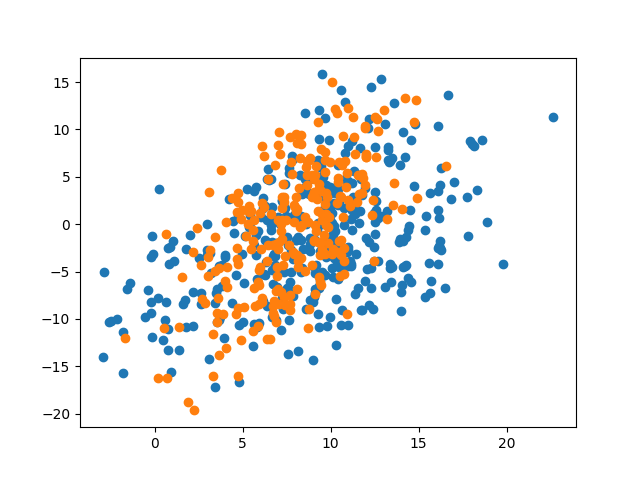

In [23]:
# 4a. Select pixels from the primary visual cortex (V1) or the trunk subregion of the somatosensory cortex
dff_space_PCs = PCA2.transform(dff_space)[:, :2]
# boolean vectors for each area
v1_idx   = area_lbl=='VISp'
sstr_idx = area_lbl=='SSp-tr'



# FILL IN:
# now use these to index into the first two temporal PCs
# you should end up with a 390 x 2 matrix for V1, and 260 x 2 for SStr
v1_PCs = dff_space_PCs[v1_idx,:]
sstr_PCs = dff_space_PCs[sstr_idx,:]

# FILL IN:
# Plot the PC1 and PC2 values for each pixel on the same axis, using different colors for each area
# Do you think these will be linearly separable?
fig, ax = plt.subplots()
ax.scatter(v1_PCs[:,0], v1_PCs[:,1])
ax.scatter(sstr_PCs[:,0], sstr_PCs[:,1])


In [24]:
# Train a linear or kernel SVM using 10-fold cross -validation.
# Print the average cross-validated accuracy. Were your suspicions confirmed?

# set up cross-val
num_fold    = 10
kf          = KFold(n_splits=num_fold)
model_lin   = SVC(kernel='linear')
model_rbf   = SVC(kernel='rbf')
acc_lin     = []
acc_rbf     = []

# FILL IN:
# set up X and y by concatenating your vectors
X = np.vstack((v1_PCs, sstr_PCs))
y = np.ones((X.shape[0]))
y[:v1_PCs.shape[0]] = 0 #v1 is 0


# cross validate
for iXval, (train_index, test_index) in enumerate(kf.split(X)):
    thismodel = model_lin.fit(X[train_index,:],y[train_index])
    yhat      = thismodel.predict(X[test_index,:])
    acc       = sum(yhat==y[test_index])/len(test_index)
    acc_lin.append(acc)

    thismodel = model_rbf.fit(X[train_index,:],y[train_index])
    yhat      = thismodel.predict(X[test_index,:])
    acc       = sum(yhat==y[test_index])/len(test_index)
    acc_rbf.append(acc)

print(np.mean(np.array(acc_lin)))
print(np.mean(np.array(acc_rbf)))

#yes unable to cluster

0.4323076923076923
0.31384615384615383
